In [6]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;
}

<IPython.core.display.Javascript object>

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from random import randrange
import progressbar
from sklearn.cluster import AgglomerativeClustering as agc
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from statsmodels.tsa.arima_model import ARIMA

SELECT_NUMBER = 1000

random.seed(1)
x_axis = np.arange(0, 29-1/288, 1/288).tolist()
np_cpu = np.load("wetransfer-2ee104//google-cpu-full.npy")

In [15]:
selected_machines = pd.read_csv("df_updated_selected_machines.csv", header = None)
selected_machines = selected_machines[1]

# df_cpu is a dataframe with all the cpu utilisation data (columns = machine; rows = time)
# dropping last 32 lines with corrupted data

df_cpu = pd.DataFrame(np_cpu).transpose()
df_selected_machines = df_cpu[selected_machines].drop(df_cpu.tail(32).index)

In [16]:
def kmeans_cluster_map(cpu_t, number_of_cluster = 50):
    # takes in cpu at a single time index and creates a map of cluster index to list of machine index in the cluster
    # cpu_t is a pd.series with values of cpu at time t 
    
    
    
    # get machine index
    machine_index = cpu_t.columns
    number_of_machine = len(machine_index)
    
    # converting cpu_t to appropriate data structure
    cpu_t = cpu_t.mean().values.reshape(-1,1)
    
    # computing the clusters
    kmeans = KMeans(n_clusters=number_of_cluster, random_state = 0)
    clustering_output = kmeans.fit(cpu_t).labels_
    
    # initialising a map for clusters
    cluster_map = {}
    for x in range(0,number_of_cluster):
        cluster_map[x] = []

    # get a map for each cluster
    # key is cluster index; values is list of machines in that cluster
    for x in range(0,number_of_machine):
        cluster_map[clustering_output[x]].append(machine_index[x])
        
    return cluster_map

def arima_predictions(timeseries, input_arima_order = (3,0,0)):
    # takes in a timeseries
    # outputs a single prediction in the next timestep
    
    timeseries = timeseries.values
    model = ARIMA(timeseries, order = input_arima_order)
    model_fit = model.fit(disp=0)
    prediction = model_fit.forecast()[0][0]
    
    return prediction

def mse_cluster_prediction(cpu_data, input_arima_order, past_error):
    # generate predictions for all machines in cluster at next single timestep
    # returns a map of machine to predictions
    
    # get generalisation model (analogous to best_machine in correlation_prediction)
    general_model = cpu_data.mean(axis = 1)
    
    # make predictions on best machine
    general_model_prediction = arima_predictions(general_model, input_arima_order = input_arima_order)
    
    # get the rolling_error
    rolling_error = past_error.mean()
    
    # scale general_model to fit all the other machines
    cluster_prediction = dict()
    for index, machine_index in enumerate(cpu_data.columns):
        cluster_prediction[machine_index] = general_model_prediction + rolling_error[machine_index]
        
    return cluster_prediction    

def mse_predictions(cpu_data, number_of_cluster = 50, start_time = 288, end_time = None, past_error_range = 5, rolling_cluster_window = 5):
    arima_order = (3,0,0)
    machine_index = cpu_data.columns
    number_of_machine = len(cpu_data.columns)
    all_predictions = pd.DataFrame(columns = cpu_data.columns)
    df_past_error = pd.DataFrame(0, columns = cpu_data.columns, index = np.arange(0,past_error_range))
    
    if end_time == None:
        end_time = len(cpu_data.index) - 1
    
    with progressbar.ProgressBar(max_value = end_time-start_time) as bar:
        for current_time in range(start_time, end_time):
    
            bar.update(current_time-start_time)
        
            # reset current prediction map
            curr_all_machine_pred = {}

            # perform clustering at current time index
            # note clustering is only done using average of last "rolling_cluster_window" points
            cluster = kmeans_cluster_map(cpu_data.iloc[current_time - rolling_cluster_window + 1: current_time + 1], 
                                         number_of_cluster = number_of_cluster)

            # initialise dict for machine to prediction in current timestep
            curr_all_machine_pred = dict()

            for ls_machine_in_cluster in cluster.values():
#                 print("ls_machine_in_cluster : ", ls_machine_in_cluster)
                
                # make predictions for all machine in each cluster
                cluster_predictions = mse_cluster_prediction(cpu_data = cpu_data[ls_machine_in_cluster], 
                                                             input_arima_order = (3,0,0), 
                                                             past_error = df_past_error[ls_machine_in_cluster])
            
#                 print("cluster_predictions : ", cluster_predictions)
                
                # curr_all_machine_pred is a dict with key = machine, value = current timestep prediction
                curr_all_machine_pred = {**curr_all_machine_pred, **cluster_predictions}
                
#             print("curr_all_machine_pred : ", curr_all_machine_pred)

            # update df_past_error with most updated time index
            # start by getting the current error
            curr_all_machine_error = cpu_data.iloc[current_time+1] - pd.DataFrame(curr_all_machine_pred, index = [current_time+1])
#             print("curr_all_machine_error : ", curr_all_machine_error)
            
            df_past_error = df_past_error.append(curr_all_machine_error, 
                                                 ignore_index = True)
            df_past_error = df_past_error.drop(0).reset_index().drop("index", axis = 1)
#             print("df_past_error : ", df_past_error)
            
            # append the current predicition to all the predictions
            current_df = pd.DataFrame(curr_all_machine_pred, index = [current_time+1])
#             print("current_df : ", current_df)
            
            all_predictions = all_predictions.append(current_df, sort = True)
        
    return all_predictions

In [17]:
rolling_5 = mse_predictions(df_selected_machines, 
                                   number_of_cluster = 50, 
                                   start_time = 288, 
                                   end_time = 288+72,
                                   past_error_range = 5, 
                                   rolling_cluster_window = 5)

rolling_3 = mse_predictions(df_selected_machines, 
                                   number_of_cluster = 50, 
                                   start_time = 288, 
                                   end_time = 288+72,
                                   past_error_range = 3, 
                                   rolling_cluster_window = 3)

rolling_7 = mse_predictions(df_selected_machines, 
                                   number_of_cluster = 50, 
                                   start_time = 288, 
                                   end_time = 288+72,
                                   past_error_range = 7, 
                                   rolling_cluster_window = 7)

100% (72 of 72) |########################| Elapsed Time: 0:17:02 Time:  0:17:02
 19% (14 of 72) |####                    | Elapsed Time: 0:02:59 ETA:   0:11:57/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 20% (15 of 72) |#####                   | Elapsed Time: 0:03:13 ETA:   0:13:30/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 31% (23 of 72) |#######                 | Elapsed Time: 0:05:07 ETA:   0:10:50/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
 36% 

In [25]:
((rolling_3.reset_index() - df_selected_machines[289:361].reset_index())**2).mean().mean()

0.014649238160274419

In [21]:
((rolling_5 - df_selected_machines[289:361])**2).mean().mean()

0.014942982578305135

In [22]:
((rolling_7 - df_selected_machines[289:361])**2).mean().mean()

0.01534071651013925

In [111]:
def get_machine_predictions(machine_timeseries, start_time, end_time, input_arima_order = (3,0,3)):
    # takes in timeseries of one machine
    # machine_timeseries is a pd.series
    # returns a list of predicted values of time start_time+1 to end_time+1
    
    machine_prediction = []
    
    for current_time in range (start_time, end_time):
        # when current_time = t, generates predictions for t+1
        
        current_timeseries = machine_timeseries[:current_time].values
        model = ARIMA(current_timeseries, order = input_arima_order)
        model_fit = model.fit(disp=0)
        current_prediction = model_fit.forecast()[0][0]
        
        machine_prediction.append(current_prediction)
    
    return machine_prediction

df_0 = pd.Series(get_machine_predictions(df_cpu[0], start_time = 288, end_time = 288+72), index = np.arange(289,289+72))

/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/yeehonglow/Library/Python/3.7/lib/python/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  '

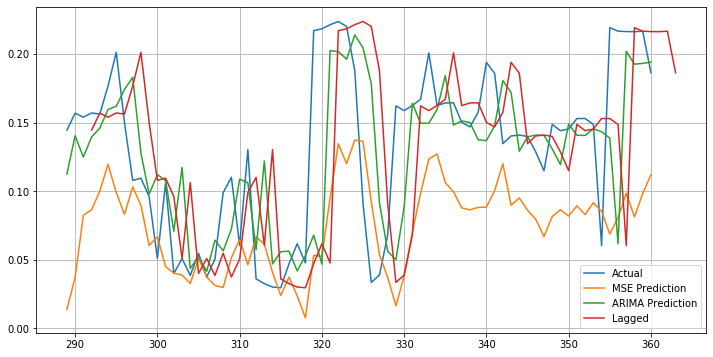

In [126]:
plt.figure(figsize= (12,6))
plt.plot(df_selected_machines[0].iloc[289:289+72], label = "Actual")
plt.plot(test_predictions[0], label = "MSE Prediction")
plt.plot(df_0, label = "ARIMA Prediction")
plt.plot(lagged, label = "Lagged")
plt.legend()
plt.grid()

In [127]:
df_cpu

,0,1,2,3,4,5,6,7,8,9,...,12466,12467,12468,12469,12470,12471,12472,12473,12474,12475
0,0.253672,0.079161,0.206047,0.663605,0.382621,0.295668,0.184070,0.496593,0.525418,0.290140,...,0.375723,0.408478,0.210300,0.736583,0.197652,0.252940,0.502969,0.491815,0.385068,0.162004
1,0.244409,0.085044,0.196264,0.818703,0.402819,0.297955,0.213957,0.350278,0.573250,0.317034,...,0.470169,0.412815,0.166844,0.809824,0.162657,0.290303,0.412357,0.445945,0.468362,0.334348
2,0.286186,0.126529,0.245121,0.830427,0.411507,0.296759,0.351503,0.293486,0.555317,0.368492,...,0.483236,0.413504,0.164896,0.543337,0.232658,0.270588,0.161209,0.476118,0.486091,0.241277
3,0.282959,0.567100,0.784541,0.805947,0.411052,0.310281,0.368436,0.293222,0.528925,0.279950,...,0.472866,0.433755,0.169487,0.800869,0.217257,0.293129,0.564685,0.748201,0.744447,0.246259
4,0.267864,0.568513,0.625622,0.788383,0.398860,0.354702,0.362917,0.414586,0.548902,0.245887,...,0.470394,0.079542,0.161834,0.829667,0.250794,0.277118,0.516919,0.705893,0.711830,0.307020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8348,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [125]:
lagged = pd.Series(lagged, index = np.arange(289+3,289+72+3))

In [130]:
df_cpu.iloc[1] + df_cpu.iloc[2]

0        0.530595
1        0.211573
2        0.441385
3        1.649130
4        0.814325
           ...   
12471    0.560891
12472    0.573566
12473    0.922063
12474    0.954453
12475    0.575625
Length: 12476, dtype: float64